In this build, we are building a xgboost model. 

The imputation methods are:
- Categorical: fill in with "NA"
- Numeric: fill in with -999

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import xgboost as xgb
import pprint as pp
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import bnp_helper
import common_helper
import random
import os
import datetime
from sklearn.externals import joblib
from matplotlib.pylab import rcParams
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline
rcParams['figure.figsize'] = 16, 4
pd.set_option('display.max_columns', 500)

/Users/binlin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
################### Combine the training set and test set to fix the unmatched categories ############
train_df_raw = pd.read_csv("../data/train.csv")
test_df_raw = pd.read_csv("../data/test.csv")

df_raw_combined = pd.concat([train_df_raw, test_df_raw], axis = 0)

########### Clean and Impute (Combined) #############
df_combinded = bnp_helper.clean(df_raw_combined, drop_collinearity = True, inplace = True)
df_combinded = bnp_helper.impute_cate_with_na_numeric_with_outlier(df_combinded)

################ Convert text to number (Combined) ################
df_combinded = common_helper.dummify(df_combinded, bnp_helper.get_categorical_variables(df_combinded))
print df_combinded.shape
df_combinded.head()

In [72]:
train_df = df_combinded[-df_raw_combined['target'].isnull()]
test_df = df_combinded[df_raw_combined['target'].isnull()]

train_df_sample = train_df.sample(50000, random_state = 0)
#train_df_sample = train_df
target_train = train_df_sample['target']
X_train = train_df_sample.drop(['ID', 'target'], axis = 1)

In [3]:
############ Create a ExtraTreesClassifier with initial parameters ########
model = ExtraTreesClassifier(    
    n_estimators = 100,             # Number of trees
    max_features = 0.8,             # Number of features for each tree
    max_depth = 10,                 # Depth of the tree
    min_samples_split = 2,          # Minimum number of samples required to split an internal node
    min_samples_leaf = 1,           # Minimum number of samples in a leaf
    min_weight_fraction_leaf = 0,   # Minimum weighted fraction of the input samples required to be at a leaf node. 
    #max_leaf_nodes = None,
    criterion = 'gini',             # Use gini, not going to tune it
    random_state = 27,
    n_jobs = -1)

model run time: 0:00:17.930121
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features=0.8, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=27, verbose=0, warm_start=False)
Log Loss: 0.443268400674
Accuracy : 0.7917


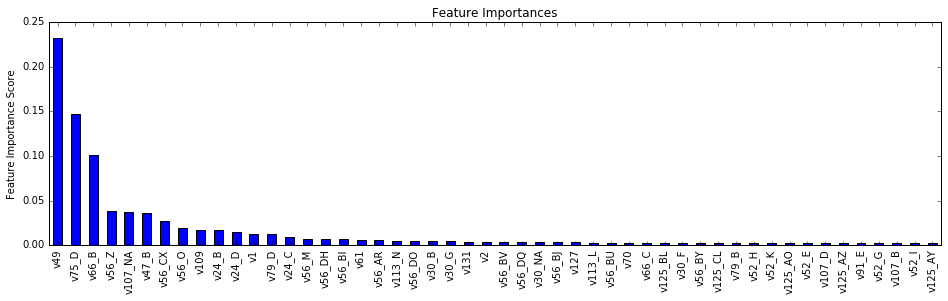

In [73]:
############### First try ############
start = datetime.datetime.now()
model_fit = model.fit(X_train, target_train)
end = datetime.datetime.now()
print "model run time: {}".format(end - start)

print model_fit

predprob_train = model.predict_proba(X_train)
log_loss = metrics.log_loss(target_train, predprob_train)
print "Log Loss: {}".format(log_loss)

pred_train = model.predict(X_train)
print "Accuracy : %.4g" % metrics.accuracy_score(target_train, pred_train)

# Plot feature importance
feature_score = common_helper.get_feature_importance(train_df_sample, model)
bnp_helper.feature_importance_plot(dict(feature_score), 50)

In [4]:
train_df = df_combinded[-df_raw_combined['target'].isnull()]
test_df = df_combinded[df_raw_combined['target'].isnull()]

train_df_sample = train_df.sample(50000, random_state = 0)
#train_df_sample = train_df
target_train = train_df_sample['target']
X_train = train_df_sample.drop(['ID', 'target'], axis = 1)

In [5]:
####### Coarse Tune Parameters #######
para_grid = [{    
    'max_features': [0.6, 0.75, 0.9],  # Number of features for each tree
    'max_depth': [5, 15, 25],          # Depth of the tree
    'min_samples_split': [5, 10, 50],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [5, 10, 50]    # Minimum number of samples in a leaf
    }]

start = datetime.datetime.now()
para_search = GridSearchCV(model, para_grid, scoring = 'log_loss', cv = 5, n_jobs = 4).fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

pp.pprint(para_search.grid_scores_)

# best combinatin
print 'Best combination: ', para_search.best_params_

# best score
print 'Best Score' , para_search.best_score_

model training time: 2:12:58.617816
[mean: -0.49928, std: 0.00249, params: {'max_features': 0.6, 'min_samples_split': 5, 'max_depth': 5, 'min_samples_leaf': 5},
 mean: -0.49928, std: 0.00249, params: {'max_features': 0.6, 'min_samples_split': 10, 'max_depth': 5, 'min_samples_leaf': 5},
 mean: -0.49924, std: 0.00245, params: {'max_features': 0.6, 'min_samples_split': 50, 'max_depth': 5, 'min_samples_leaf': 5},
 mean: -0.49920, std: 0.00251, params: {'max_features': 0.6, 'min_samples_split': 5, 'max_depth': 5, 'min_samples_leaf': 10},
 mean: -0.49920, std: 0.00251, params: {'max_features': 0.6, 'min_samples_split': 10, 'max_depth': 5, 'min_samples_leaf': 10},
 mean: -0.49911, std: 0.00246, params: {'max_features': 0.6, 'min_samples_split': 50, 'max_depth': 5, 'min_samples_leaf': 10},
 mean: -0.49920, std: 0.00248, params: {'max_features': 0.6, 'min_samples_split': 5, 'max_depth': 5, 'min_samples_leaf': 50},
 mean: -0.49920, std: 0.00248, params: {'max_features': 0.6, 'min_samples_split':

In [6]:
####### Now Fine Tune Parameters #######
para_grid = [{    
    'max_features': [0.85, 0.9, 0.95],  # Number of features for each tree
    'max_depth': [20, 25, 30],         # Depth of the tree
    'min_samples_split': [3, 5, 7], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [45, 50, 55]  # Minimum number of samples in a leaf
    }]

start = datetime.datetime.now()
para_search = GridSearchCV(model, para_grid, scoring = 'log_loss', cv = 5, n_jobs = 4).fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

pp.pprint(para_search.grid_scores_)

# best combinatin
print 'Best combination: ', para_search.best_params_

# best score
print 'Best Score' , para_search.best_score_

model training time: 3:02:57.592545
[mean: -0.47385, std: 0.00298, params: {'max_features': 0.85, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 45},
 mean: -0.47385, std: 0.00298, params: {'max_features': 0.85, 'min_samples_split': 5, 'max_depth': 20, 'min_samples_leaf': 45},
 mean: -0.47385, std: 0.00298, params: {'max_features': 0.85, 'min_samples_split': 7, 'max_depth': 20, 'min_samples_leaf': 45},
 mean: -0.47402, std: 0.00290, params: {'max_features': 0.85, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 50},
 mean: -0.47402, std: 0.00290, params: {'max_features': 0.85, 'min_samples_split': 5, 'max_depth': 20, 'min_samples_leaf': 50},
 mean: -0.47402, std: 0.00290, params: {'max_features': 0.85, 'min_samples_split': 7, 'max_depth': 20, 'min_samples_leaf': 50},
 mean: -0.47406, std: 0.00259, params: {'max_features': 0.85, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 55},
 mean: -0.47406, std: 0.00259, params: {'max_features': 0.85, 'min_s

In [7]:
####### Now Fine Tune Parameters #######
para_grid = [{    
    'max_features': [0.83, 0.85, 0.87], # Number of features for each tree
    'max_depth': [25],                  # Depth of the tree
    'min_samples_split': [2, 3, 4],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [42, 45, 48]    # Minimum number of samples in a leaf
    }]

start = datetime.datetime.now()
para_search = GridSearchCV(model, para_grid, scoring = 'log_loss', cv = 5, n_jobs = 4).fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

pp.pprint(para_search.grid_scores_)

# best combinatin
print 'Best combination: ', para_search.best_params_

# best score
print 'Best Score' , para_search.best_score_

model training time: 0:58:13.487039
[mean: -0.47367, std: 0.00283, params: {'max_features': 0.83, 'min_samples_split': 2, 'max_depth': 25, 'min_samples_leaf': 42},
 mean: -0.47367, std: 0.00283, params: {'max_features': 0.83, 'min_samples_split': 3, 'max_depth': 25, 'min_samples_leaf': 42},
 mean: -0.47367, std: 0.00283, params: {'max_features': 0.83, 'min_samples_split': 4, 'max_depth': 25, 'min_samples_leaf': 42},
 mean: -0.47373, std: 0.00308, params: {'max_features': 0.83, 'min_samples_split': 2, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47373, std: 0.00308, params: {'max_features': 0.83, 'min_samples_split': 3, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47373, std: 0.00308, params: {'max_features': 0.83, 'min_samples_split': 4, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47375, std: 0.00280, params: {'max_features': 0.83, 'min_samples_split': 2, 'max_depth': 25, 'min_samples_leaf': 48},
 mean: -0.47375, std: 0.00280, params: {'max_features': 0.83, 'min_s

In [10]:
####### Now Fine Tune Parameters #######
para_grid = [{    
    'max_features': [0.86, 0.87, 0.88],  # Number of features for each tree
    'max_depth': [25],                   # Depth of the tree
    'min_samples_split': [2],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [45]             # Minimum number of samples in a leaf
    }]

start = datetime.datetime.now()
para_search = GridSearchCV(model, para_grid, scoring = 'log_loss', cv = 5, n_jobs = 4).fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

pp.pprint(para_search.grid_scores_)

# best combinatin
print 'Best combination: ', para_search.best_params_

# best score
print 'Best Score' , para_search.best_score_

model training time: 0:07:16.096399
[mean: -0.47371, std: 0.00310, params: {'max_features': 0.86, 'min_samples_split': 2, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47354, std: 0.00293, params: {'max_features': 0.87, 'min_samples_split': 2, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47354, std: 0.00313, params: {'max_features': 0.88, 'min_samples_split': 2, 'max_depth': 25, 'min_samples_leaf': 45}]
Best combination:  {'max_features': 0.87, 'min_samples_split': 2, 'max_depth': 25, 'min_samples_leaf': 45}
Best Score -0.473539680593


In [12]:
####### Now find a good number for number of trees #######
para_grid = [{    
    'n_estimators': [100, 300, 500, 700], 
    'max_features': [0.87],              # Number of features for each tree
    'max_depth': [25],                   # Depth of the tree
    'min_samples_split': [2],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [45]             # Minimum number of samples in a leaf
    }]

start = datetime.datetime.now()
para_search = GridSearchCV(model, para_grid, scoring = 'log_loss', cv = 5, n_jobs = 4).fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

pp.pprint(para_search.grid_scores_)

# best combinatin
print 'Best combination: ', para_search.best_params_

# best score
print 'Best Score' , para_search.best_score_


model training time: 0:47:32.837845
[mean: -0.47354, std: 0.00293, params: {'max_features': 0.87, 'min_samples_split': 2, 'n_estimators': 100, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47342, std: 0.00310, params: {'max_features': 0.87, 'min_samples_split': 2, 'n_estimators': 300, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47335, std: 0.00300, params: {'max_features': 0.87, 'min_samples_split': 2, 'n_estimators': 500, 'max_depth': 25, 'min_samples_leaf': 45},
 mean: -0.47331, std: 0.00300, params: {'max_features': 0.87, 'min_samples_split': 2, 'n_estimators': 700, 'max_depth': 25, 'min_samples_leaf': 45}]
Best combination:  {'max_features': 0.87, 'min_samples_split': 2, 'n_estimators': 700, 'max_depth': 25, 'min_samples_leaf': 45}
Best Score -0.473314161802


In [51]:
############ Now use full training set to train ##############
train_df_sample = train_df
target_train = train_df_sample['target']
X_train = train_df_sample.drop(['ID', 'target'], axis = 1)

In [66]:
# best estimator
model_best = para_search.best_estimator_
model_best.fit(X_train, target_train)

joblib.dump(model_best, 'save/extratree/extratree_model.pkl')

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=25, max_features=0.87, max_leaf_nodes=None,
           min_samples_leaf=45, min_samples_split=2,
           min_weight_fraction_leaf=0, n_estimators=700, n_jobs=-1,
           oob_score=False, random_state=27, verbose=0, warm_start=False)

In [67]:
predprob_train = model_best.predict_proba(X_train)
metrics.log_loss(target_train, predprob_train)

0.46891486620978429

In [68]:
################# Predict the test set and save result to file ############
#test_df_sample = test_df.sample(1000, random_state = 0)
test_df_sample = test_df

X_test = test_df_sample.drop(['ID', 'target'], axis = 1)

#Predict test set:
predprob_test = model_best.predict_proba(X_test)
        
# Save results
ids = test_df_sample['ID']
predprob_one_test = [p[1] for p in predprob_test]
bnp_helper.save_result(ids, predprob_one_test, "results/extraetree_model_result.csv")

print 'Done at: {}'.format(datetime.datetime.now())

Done at: 2016-04-13 18:15:38.215970
